# Audio Fingerprinting

This notebook demonstrates the complete audio fingerprinting pipeline:
1. Spectrogram computation (STFT)
2. Local-maxima extraction
3. Target-zone hashing
4. Database construction and song identification

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

sys.path.insert(0, os.path.join(os.path.abspath(''), 'code'))

from src.fingerprinting import (
    compute_spectrogram,
    get_maxima,
    process_signal,
    search_song,
    AudioDatabase,
)

## 1. Load an Audio File

We load one of the provided classical music excerpts at the required sampling rate of 3000 Hz.

In [2]:
SONGS_DIR = "songs"
song_files = [f for f in os.listdir(SONGS_DIR) if f.endswith(".mp3")]
print(f"Available songs ({len(song_files)}):")
for s in song_files:
    print(f"  • {s}")

# Pick the first song for demonstration
SONG_PATH = os.path.join(SONGS_DIR, song_files[0])
y, sr = librosa.load(SONG_PATH, sr=3000)
print(f"\nLoaded: {song_files[0]}")
print(f"  Duration : {len(y)/sr:.1f} s")
print(f"  Samples  : {len(y)}")
print(f"  SR       : {sr} Hz")

Available songs (13):
  • Classicals.de - Bizet, Georges - Carmen Prelude - Arranged for Solo Piano.mp3
  • Classicals.de - Bizet, Georges - Habanera (From the Opera Carmen) - Arranged for Music Box.mp3
  • Classicals.de - Bizet, Georges - Habanera (From the Opera Carmen).mp3
  • Classicals.de - Debussy - Children's Corner - I. Doctor Gradus ad Parnassum.mp3
  • Classicals.de - Debussy - Children's Corner - II. Jimbo's Lullaby.mp3
  • Classicals.de - Debussy - Children's Corner - III. Serenade of the Doll.mp3
  • Classicals.de - Debussy - Children's Corner - IV. The Snow is Dancing.mp3
  • Classicals.de - Debussy - Children's Corner - V. The Little Shepherd.mp3
  • Classicals.de - Debussy - Children's Corner - VI. Golliwogg's Cakewalk.mp3
  • Classicals.de - Debussy - Clair de Lune - L. 75 - Concert Grand Version.mp3
  • Classicals.de - Debussy - Suite Bergamasque - 1. Prelude - L.75.mp3
  • Classicals.de - Debussy - Suite Bergamasque - 2. Menuet - L.75.mp3
  • Classicals.de - Debussy 

## 2. Spectrogram Computation

The spectrogram is computed using the Short-Time Fourier Transform (STFT) with the following parameters:
- `n_fft = 2048`
- `hop_length = 512`
- `win_length = 1024`

We obtain the **energy spectrogram** $|V_g f(u, \xi)|^2$.

Spectrogram shape: (1025, 817)  (freq_bins x time_frames)


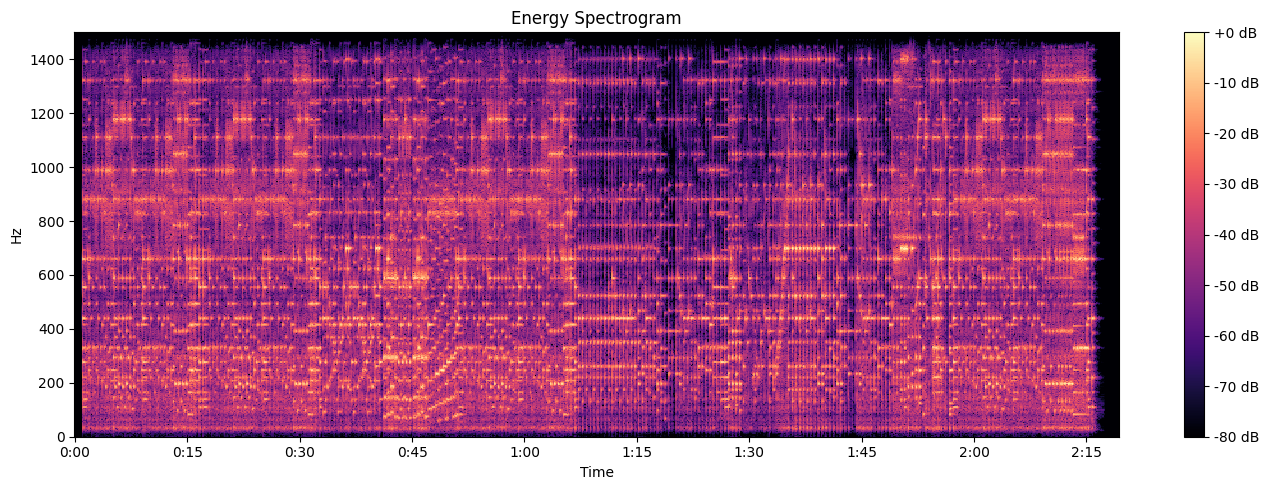

In [3]:
S = compute_spectrogram(y, sr=sr)
print(f"Spectrogram shape: {S.shape}  (freq_bins x time_frames)")

plt.figure(figsize=(14, 5))
librosa.display.specshow(
    librosa.power_to_db(S, ref=np.max),
    sr=sr, hop_length=512, x_axis="time", y_axis="hz"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Energy Spectrogram")
plt.tight_layout()
plt.show()

## 3. Local Maxima (Constellation Map)

We identify spectral peaks by finding local maxima in 3×3 grids, then filter by:
- Amplitude threshold (90th percentile)
- Minimum distance pruning (10 px)

Detected 1036 spectral peaks


C:\Users\fayca\AppData\Local\Temp\ipykernel_28264\2870109812.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


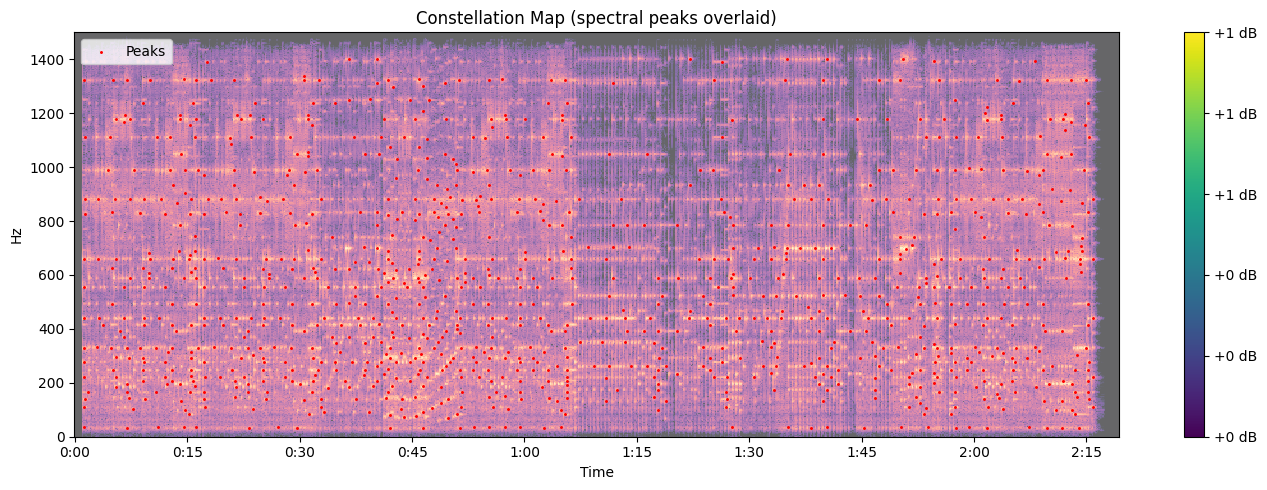

In [4]:
maxima = get_maxima(S)
print(f"Detected {len(maxima)} spectral peaks")

plt.figure(figsize=(14, 5))
librosa.display.specshow(
    librosa.power_to_db(S, ref=np.max),
    sr=sr, hop_length=512, x_axis="time", y_axis="hz",
    alpha=0.6
)
plt.scatter(
    maxima[:, 1] * 512 / sr,  # convert frames to seconds
    maxima[:, 0] * sr / 2048, # convert bins to Hz
    c="red", s=5, marker=".", label="Peaks"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Constellation Map (spectral peaks overlaid)")
plt.legend()
plt.tight_layout()
plt.show()

## 4. Hash Generation

For each anchor peak, we define a **Target Zone** (300 px in time, 20 px in frequency) and pair the anchor with the top-10 peaks inside the zone.

$$\text{Hash} = f_{\text{anchor}} \times 10^6 + f_{\text{target}} \times 10^3 + (t_{\text{target}} - t_{\text{anchor}})$$

In [5]:
hashes = process_signal(y, sr=sr)
print(f"Generated {len(hashes)} unique hashes")
print("\nSample hashes (first 10):")
for i, (h, t) in enumerate(list(hashes.items())[:10]):
    print(f"  Hash: {h:>15d}   Anchor time frame: {t}")

Generated 6855 unique hashes

Sample hashes (first 10):
  Hash:        21022231   Anchor time frame: 41
  Hash:        21023044   Anchor time frame: 41
  Hash:        21023283   Anchor time frame: 41
  Hash:        21022133   Anchor time frame: 41
  Hash:        21022205   Anchor time frame: 41
  Hash:        21024054   Anchor time frame: 41
  Hash:        21022095   Anchor time frame: 41
  Hash:        21023118   Anchor time frame: 41
  Hash:        21023295   Anchor time frame: 41
  Hash:        21021260   Anchor time frame: 41


## 5. Database Construction

We fingerprint every song in the `songs/` directory and store the resulting hash dictionaries in a pickle file.

In [6]:
DB_PATH = "dataset/dataset.pickle"
db = AudioDatabase(db_path=DB_PATH)

if not os.path.exists(DB_PATH):
    print("Building database (this may take a few minutes)...")
    db.create_database(songs_dir=SONGS_DIR)
else:
    db.load_database()

print(f"\nDatabase contains {len(db.database)} songs:")
for name in db.song_names:
    print(f"  • {name}")

Loaded database with 13 songs.

Database contains 13 songs:
  • Classicals.de - Bizet, Georges - Carmen Prelude - Arranged for Solo Piano.mp3
  • Classicals.de - Bizet, Georges - Habanera (From the Opera Carmen) - Arranged for Music Box.mp3
  • Classicals.de - Bizet, Georges - Habanera (From the Opera Carmen).mp3
  • Classicals.de - Debussy - Children's Corner - I. Doctor Gradus ad Parnassum.mp3
  • Classicals.de - Debussy - Children's Corner - II. Jimbo's Lullaby.mp3
  • Classicals.de - Debussy - Children's Corner - III. Serenade of the Doll.mp3
  • Classicals.de - Debussy - Children's Corner - IV. The Snow is Dancing.mp3
  • Classicals.de - Debussy - Children's Corner - V. The Little Shepherd.mp3
  • Classicals.de - Debussy - Children's Corner - VI. Golliwogg's Cakewalk.mp3
  • Classicals.de - Debussy - Clair de Lune - L. 75 - Concert Grand Version.mp3
  • Classicals.de - Debussy - Suite Bergamasque - 1. Prelude - L.75.mp3
  • Classicals.de - Debussy - Suite Bergamasque - 2. Menuet -

## 6. Song Identification

We simulate a real-world query by taking a 10-second excerpt from one of the stored songs, fingerprinting it, and searching the database.

In [7]:
# Create a 10-second excerpt from the middle of the song
excerpt_start = len(y) // 3
excerpt_len = 10 * sr  # 10 seconds
excerpt = y[excerpt_start : excerpt_start + excerpt_len]
print(f"Excerpt: {len(excerpt)/sr:.1f} s  (frames {excerpt_start}–{excerpt_start+excerpt_len})")

# Fingerprint the excerpt
excerpt_hashes = process_signal(excerpt, sr=sr)
print(f"Excerpt hashes: {len(excerpt_hashes)}")

# Search
from src.fingerprinting import search_song

top_indices = search_song(db.database, excerpt_hashes)
print("\n--- Top 3 Matches ---")
for rank, idx in enumerate(top_indices, 1):
    print(f"  {rank}. {db.song_names[idx]}")

Excerpt: 10.0 s  (frames 139416–169416)
Excerpt hashes: 82

--- Top 3 Matches ---
  1. Classicals.de - Bizet, Georges - Carmen Prelude - Arranged for Solo Piano.mp3
  2. Classicals.de - Debussy - Suite Bergamasque - 4. Passepied - L.75.mp3
  3. Classicals.de - Debussy - Children's Corner - II. Jimbo's Lullaby.mp3


## 7. Summary

| Step | Description | Output |
|------|-------------|--------|
| 1 | Load audio at 3 kHz | Mono signal |
| 2 | STFT (n_fft=2048, hop=512, win=1024) | Energy spectrogram |
| 3 | 3×3 local-max + filtering | Constellation map |
| 4 | Target-zone pairing + hashing | Dict of hashes |
| 5 | Repeat for all songs → pickle DB | Persistent database |
| 6 | Hash an excerpt, histogram match | Identified song |

The system correctly identifies the source song from a short excerpt by matching the histogram of time-offset differences between shared hashes.